<br>
<br>

Put some introduction here. 

<br>
<br>


In [20]:
# import required modules/packages

import os
import string
import subprocess
import numpy as np
from collections import OrderedDict
import math
import pandas as pd
import geopandas as gpd
from scipy.spatial import Delaunay
from shapely.geometry import MultiLineString
from shapely.ops import cascaded_union, polygonize
import time

import pcraster as pcr

import matplotlib

#%matplotlib notebook
#TODO: Note that pcr.plot() still does not support interactive zoom-ing.    


In [21]:
# check the path and test 
os.system('echo $PATH')
# test aguila 
pcr.aguila()

!aguila
!ls
!echo $PATH

QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-sutan101'
libGL error: failed to open drm device: Permission denied
libGL error: failed to load driver: i965
libGL error: unable to load driver: swrast_dri.so
libGL error: failed to load driver: swrast
environment.yml		     __pycache__	tmpj5ap77o5  tmppmhi0jli
how_to_install_conda_etc.sh  remote_jupyter.sh	tmpj7njcj79  tmpqtpbq1_a
intervent_parameter.ipynb    test_4.py		tmpjhgxz166  tmpr8z07lq4
legend.tmp		     test_on_fleet.py	tmpkwmhj9eb  tmpvqq8tx51
mapIO.py		     tmp2menmed8	tmplmlz295k  tmpwz_qo11y
measures_py3.py		     tmp93bmwwdp	tmpoz78y1lp  Untitled.ipynb
pcrRecipes.py		     tmp9fyu_wcy	tmppkokj0po  untitled.txt
/opt/pcraster/pcraster-4.3/bin:/home/sutan101/opt/anaconda2/envs/rs-env/bin:/home/sutan101/opt/anaconda2/condabin:/home/sutan101/opt/anaconda2/bin:/usr/lib64/qt-3.3/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin


In [12]:
# if needed, fix the path
os.environ["PATH"] = "/opt/pcraster/pcraster-4.3/bin:/home/sutan101/opt/anaconda2/envs/rs-env/bin:/home/sutan101/opt/anaconda2/condabin:/home/sutan101/opt/anaconda2/bin:/usr/lib64/qt-3.3/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin"
pcr.aguila()

In [22]:
# import sub-modules

import mapIO
import pcrRecipes
import measures_py3 as msr



<br>
<br>

Please define output and input folders.

In [23]:
# - for test on cartesius
# output_dir  = "/scratch/depfg/sutan101/tmp_menno/out/"
# input_dir   = "/scratch/depfg/hydrowld/river_scape/source/from_menno/riverscape/input/"
# scratch_dir = "/scratch/depfg/sutan101/tmp_menno/tmp/"

# - for test on fleet
output_dir  = "/scratch/sutan101/tmp_menno/out/"
input_dir   = "/home/sutan101/data/river_scape/source/from_menno/riverscape/input/"
scratch_dir = output_dir + "/tmp/"


<br>

Please define your input (a separate manual is encouraged here).


In [24]:
#-define input
settings = OrderedDict([
                    ('smoothing_percentage', 100),
                    ('smoothing_ecotope', 'UG-2'),
                    ('smoothing_trachytope', 1201),
                    
                    ('lowering_percentage', 100),
                    ('lowering_ecotope', 'UG-2'),
                    ('lowering_trachytope', 1201),
                    ('lowering_height', 'water_level_50d'),
                    
                    ('channel_width', 75),
                    ('channel_depth', 2.5),
                    ('channel_slope', 1./3.),
                    ('channel_ecotope', 'RnM'),
                    ('channel_trachytope', 105),
                    
                    ('relocation_alpha', 10000),
                    ('relocation_depth', 'AHN'),
                    ('relocation_ecotope', 'HG-2'),
                    ('relocation_trachytope', 1201),
                    
                    ('groyne_ref_level', 'wl_exc150d'),
                    ('minemb_ref_level', 'wl_exc50d'),
                    ('main_dike_dh', 0.50),
                    ])


<br>

Start processing/calculation ....
========================

<br>


In [25]:
# starting time of this script
start_time = time.time()

In [26]:
# set global option for pcraster such that length of cells is computed in true length of cells
pcr.setglobaloption('unittrue')
# TODO: Check with Menno why we need this?

In [27]:
# set the pcraster clone map
current_dir = os.path.join(input_dir, 'reference_maps')
pcr.setclone(os.path.join(current_dir, 'clone.map'))

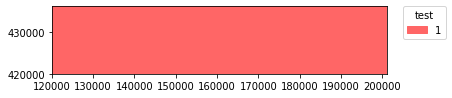

/opt/pcraster/pcraster-4.3/bin:/home/sutan101/opt/anaconda2/envs/rs-env/bin:/home/sutan101/opt/anaconda2/condabin:/home/sutan101/opt/anaconda2/bin:/usr/lib64/qt-3.3/bin:/usr/local/bin:/usr/bin:/usr/local/sbin:/usr/sbin
QStandardPaths: XDG_RUNTIME_DIR not set, defaulting to '/tmp/runtime-sutan101'
libGL error: failed to open drm device: Permission denied
libGL error: failed to load driver: i965
libGL error: unable to load driver: swrast_dri.so
libGL error: failed to load driver: swrast


In [28]:
# check and plot the clone map
test = pcr.readmap(os.path.join(current_dir, 'clone.map'))

pcr.aguila(test)
pcr.plot(test) 

!echo $PATH
!aguila

In [29]:
# import data
main_dike = msr.read_dike_maps(current_dir, 'main_dike')
minemb = msr.read_dike_maps(current_dir, 'minemb')
groynes = msr.read_dike_maps(current_dir, 'groyne')
hydro = msr.read_hydro_maps(current_dir)
mesh = msr.read_mesh_maps(current_dir)
axis = msr.read_axis_maps(current_dir)
lulc = msr.read_lulc_maps(current_dir)
geom = msr.read_geom_maps(current_dir)

In [30]:
# make scratch directory and go to this folder
pcrRecipes.make_dir(scratch_dir)
os.chdir(scratch_dir)

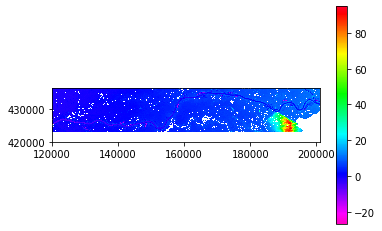

In [31]:
# plot the digital elevation model
pcr.aguila(geom.dem)
pcr.plot(geom.dem)

In [32]:
# initiate the model
waal = msr.River('Waal', axis, main_dike, minemb, groynes, hydro, 
             mesh, lulc, geom)
waal_msr = msr.RiverMeasures(waal)
waal_msr.settings = settings

In [33]:
# test measures
mask = pcr.boolean(1)
ID = 'everywhere'

In [34]:
lowering_msr = waal_msr.lowering_measure(settings, mask=mask, ID=ID)

In [35]:
lowering_msr.plot()

In [36]:
os.system("killall aguila")

0

In [37]:
groyne_low_msr = waal_msr.groyne_lowering_msr(settings, mask=mask, ID=ID)

In [38]:
minemb_low_msr = waal_msr.minemb_lowering_msr(settings, mask=mask, ID=ID)

In [39]:
main_dike_raise_msr = waal_msr.main_dike_raising_msr(settings, mask=mask, ID=ID)

In [40]:
large_sections = pcr.ifthen(pcr.areaarea(waal.geom.flpl_wide) > 1e6, waal.geom.flpl_wide)
flpl_section = pcr.ifthen(large_sections == 1, pcr.nominal(1))

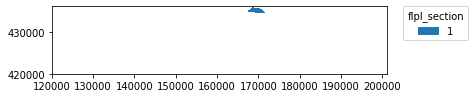

In [41]:
pcr.aguila(flpl_section)
pcr.plot(flpl_section)

In [42]:
test = list(np.unique(pcr.pcr2numpy(large_sections, -9999))[1:])
test[:]
for ID in test[:]:
    print(ID)

1
2
3
5
6
8
10
12
13
14
17
18
20
21
22
23
27
29
30
35
39
40
43
44
49
54
56


In [43]:
chan_msr = waal_msr.side_channel_measure(settings, mask=mask, ID=ID)

[1, 2, 3, 8, 10, 13, 14, 18, 20, 22, 23, 27, 30, 39, 40, 43, 49, 54, 56]
1
2
3
8
10
13
14
18
20
22
23
27
30
39
40
43
49
54
56


In [44]:
os.system("killall aguila")

256

In [45]:
smooth_msr = waal_msr.smoothing_measure(settings, mask=mask, ID=ID)

In [46]:
msr_list = [groyne_low_msr, minemb_low_msr,
            main_dike_raise_msr, lowering_msr, chan_msr, smooth_msr]

In [47]:
msr_root_dir = os.path.join(output_dir, 'measures_ensemble03/maps')

In [48]:
pcrRecipes.make_dir(msr_root_dir)

In [49]:
from measures_py3 import *

In [50]:
for measure in msr_list:
    write_measure(measure, msr_root_dir)

/scratch/sutan101/tmp_menno/out/measures_ensemble03/maps/groynelowering_everywhere
/scratch/sutan101/tmp_menno/out/measures_ensemble03/maps/minemblowering_everywhere
/scratch/sutan101/tmp_menno/out/measures_ensemble03/maps/dikeraising_everywhere
/scratch/sutan101/tmp_menno/out/measures_ensemble03/maps/lowering_everywhere
/scratch/sutan101/tmp_menno/out/measures_ensemble03/maps/sidechannel_56
/scratch/sutan101/tmp_menno/out/measures_ensemble03/maps/smoothing_56
